### Ytterligare ett test 
Efter att jag tagit bort outliers från datasetet vill jag göra ytterligare ett test för se om jag bör använda Linear Regression eller Random Forest regression för att få den bästa prediktionen. 

In [2]:
import pandas as pd
from taxipred.utils.constants import DATA_PATH
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(DATA_PATH /"taxi_clean.csv")

#Skriver ut de 5 första raderna i datasetet
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       876 non-null    float64
 1   Time_of_Day            876 non-null    object 
 2   Day_of_Week            876 non-null    object 
 3   Passenger_Count        876 non-null    float64
 4   Traffic_Conditions     876 non-null    object 
 5   Weather                876 non-null    object 
 6   Base_Fare              876 non-null    float64
 7   Per_Km_Rate            876 non-null    float64
 8   Per_Minute_Rate        876 non-null    float64
 9   Trip_Duration_Minutes  876 non-null    float64
 10  Trip_Price             876 non-null    float64
dtypes: float64(7), object(4)
memory usage: 75.4+ KB


1. Dela upp datan i X (Feature) och y (Prediction)

In [4]:
X = df.drop(columns=["Trip_Price"]) 
y = df["Trip_Price"]

2. Dela upp i test- och träningsdata

In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 10), (176, 10), (700,), (176,))

3. Dela upp numeriska och kategoriska kolumner

In [6]:
num_cols = X_train.select_dtypes(include="number").columns
cat_cols = X_train.select_dtypes(exclude="number").columns

num_cols.shape, cat_cols.shape

((6,), (4,))

4. Preprocessa datan och bygga en pipeline med sklearns inbyggd klass

In [7]:
num_transformer = Pipeline([
    ("scaler", StandardScaler())  
])

cat_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop=None))   
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ],
    remainder="drop"
)

In [8]:
#pipeline för linjär regression

lr_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

In [9]:
#pipeline för random forest regression

rf_pipe = Pipeline([
    ("preprocessor", preprocessor), 
    ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

In [10]:
lr_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:

y_pred = lr_pipe.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)          
rmse = np.sqrt(mse)                                 
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Linear regression: \nMAE: {mae:.3f}\nRMSE: {rmse:.3f}\nMSE: {mse:.3f}\nR²: {r2:.4f}")

Linear regression: 
MAE: 6.225
RMSE: 8.245
MSE: 67.988
R²: 0.8897


In [12]:
y_pred = rf_pipe.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)          
rmse = np.sqrt(mse)                                 
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Random forest regression: \nMAE: {mae:.3f}\nRMSE: {rmse:.3f}\nMSE: {mse:.3f}\nR²: {r2:.4f}")

Random forest regression: 
MAE: 4.651
RMSE: 6.589
MSE: 43.418
R²: 0.9296


In [13]:
def eval_report(y_true, y_pred, label="TEST"):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)       # kräver nyare sklearn
    r2   = r2_score(y_true, y_pred)
    print(
        f"{label}\n"
        f"  MAE : {mae:.3f}\n"
        f"  RMSE: {rmse:.3f}\n"
        f"  MSE : {mse:.3f}\n"
        f"  R²  : {r2:.4f}"
    )
    return {"label": label, "mae": mae, "rmse": rmse, "mse": mse, "r2": r2}

In [14]:
def eval_model(pipe, X_train, y_train, X_test, y_test, name):
    print(f"\n=== {name} ===")
    eval_report(y_train, pipe.predict(X_train), label="TRAIN")
    eval_report(y_test,  pipe.predict(X_test),  label="TEST")

eval_model(lr_pipe, X_train, y_train, X_test, y_test, "Linear Regression")
eval_model(rf_pipe, X_train, y_train, X_test, y_test, "Random Forest")


=== Linear Regression ===
TRAIN
  MAE : 5.849
  RMSE: 7.503
  MSE : 56.288
  R²  : 0.8943
TEST
  MAE : 6.225
  RMSE: 8.245
  MSE : 67.988
  R²  : 0.8897

=== Random Forest ===
TRAIN
  MAE : 1.699
  RMSE: 2.370
  MSE : 5.618
  R²  : 0.9895
TEST
  MAE : 4.651
  RMSE: 6.589
  MSE : 43.418
  R²  : 0.9296


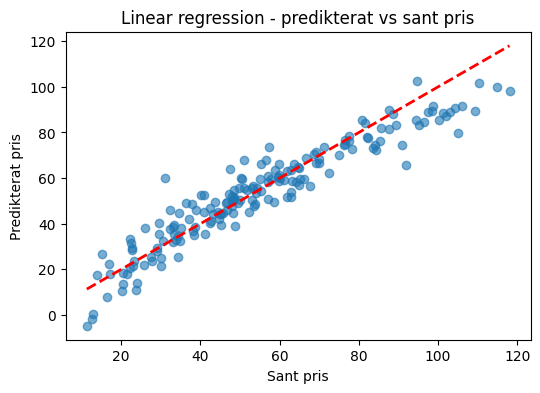

In [15]:
y_pred = lr_pipe.predict(X_test)

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2) 

plt.xlabel("Sant pris")
plt.ylabel("Predikterat pris")
plt.title("Linear regression - predikterat vs sant pris")
plt.show()

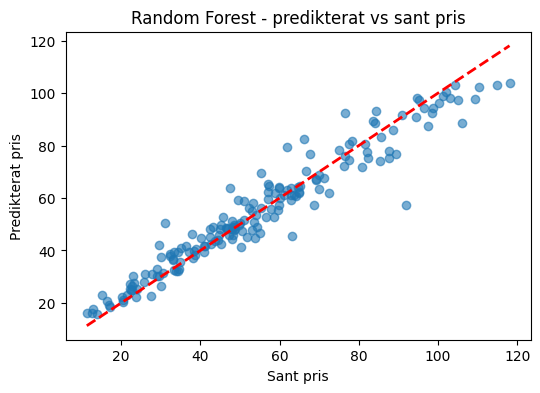

In [16]:
y_pred = rf_pipe.predict(X_test)

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2) 

plt.xlabel("Sant pris")
plt.ylabel("Predikterat pris")
plt.title("Random Forest - predikterat vs sant pris")
plt.show()


model	                            MAE	        RMSE	    R2
1	Random Forest Regression	    8.155454	11.704959	0.907202
0	Linear Regression	            9.505028	15.060462	0.846371



=== Linear Regression ===
TRAIN
  MAE : 5.849
  RMSE: 7.503
  MSE : 56.288
  R²  : 0.8943
TEST
  MAE : 6.225
  RMSE: 8.245
  MSE : 67.988
  R²  : 0.8897

=== Random Forest ===
TRAIN
  MAE : 1.699
  RMSE: 2.370
  MSE : 5.618
  R²  : 0.9895
TEST
  MAE : 4.651
  RMSE: 6.589
  MSE : 43.418
  R²  : 0.9296

##### Sammanfattning efter nytt test, där jag tagit bort outliers:
Efter att jag tagit bort outliers förbättrades resultaten för både linjär regression och Random Forest.
Random Forest har lägst MAE och RMSE samt högre R² på testdata, därför väljer jag den som produktionsmodell framför linjär regression.

Random Forest visar mycket hög R² på träningsdata (nära 1.0) men ligger runt 0.93 på testdata. Det gapet är normalt för trädmodeller och indikerar inte någon allvarlig överanpassning i detta fall.   

Jag går därför vidare och sparar modellen till joblib och kommer fortsatt att använda modellen i labben. 



In [ ]:
from sklearn.base import clone
import joblib

model = clone(rf_pipe)   # klona pipelinen så du inte skriver över den utvärderade (tips från chatGPT)
model.fit(X, y)          # tränar på ALL data

joblib.dump(model, "models/taxi_price_regressor_new.joblib")


['models/taxi_price_regressor_new.joblib']

In [2]:
import pandas as pd
import joblib
from taxipred.utils.constants import DATA_PATH

# 1) Ladda modellen du just sparade
m = joblib.load("models/taxi_price_regressor_new.joblib")

# 2) Kolla att det verkligen är en Pipeline med stegen vi vill ha
print("Loaded:", type(m).__name__)
print("Steps:", list(getattr(m, "named_steps", {}).keys()))  # bör visa ['preprocessor','model']

# 3) Offline-predict på rådata (samma format som API:t skickar in)
df = pd.read_csv(DATA_PATH / "taxi_clean.csv")
X_raw = df.drop(columns=["Trip_Price"])
sample_row = X_raw.iloc[0].to_dict()
pred = m.predict(pd.DataFrame([sample_row]))[0]
print("Offline predict OK →", float(pred))


Loaded: Pipeline
Steps: ['preprocessor', 'model']
Offline predict OK → 34.517883999999846
